The goal of this analysis is to find the factors that affect the life expectancy. Specifically, finding out which factors increase the expected life in the countries and which factors decrease it.

In [0]:
#import packages
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

In [0]:
#import data from postgres sql database
postgres_user =  'dsbc_student'
postgres_pw =  '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life = pd.read_sql_query('SELECT * FROM lifeexpectancy',con=engine) 

engine.dispose()

## Exploratory Data Analysis

In [3]:
life.info()
#data types look correct

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [4]:
life.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


### Data Cleaning & Data Exploration

In [5]:
#check percentage of missing values
life.isna().sum()/len(life)

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.003404
Adult Mortality                    0.003404
infant deaths                      0.000000
Alcohol                            0.066031
percentage expenditure             0.000000
Hepatitis B                        0.188223
Measles                            0.000000
 BMI                               0.011572
under-five deaths                  0.000000
Polio                              0.006467
Total expenditure                  0.076923
Diphtheria                         0.006467
 HIV/AIDS                          0.000000
GDP                                0.152485
Population                         0.221920
 thinness  1-19 years              0.011572
 thinness 5-9 years                0.011572
Income composition of resources    0.056841
Schooling                          0.055480
dtype: float64

Since the data is time series data, it makes sense to fill the missing continuous variables using interpolation 

In [0]:
#some column names have unexpected spaces
life.columns = life.columns.str.strip()

In [7]:
#fill columns with missing data
cols = ['Life expectancy','Adult Mortality','Alcohol','Hepatitis B','BMI','Polio','Total expenditure','Diphtheria','GDP','Population','thinness  1-19 years','thinness 5-9 years','Income composition of resources','Schooling']

countries = life.Country.unique()

for country in countries: #only interpolate for different years in the same country
    life.loc[life.Country == country,cols] = life.loc[life.Country == country,cols].interpolate()
life.isna().sum()/len(life) #checking how many missing values still remain

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.003404
Adult Mortality                    0.003404
infant deaths                      0.000000
Alcohol                            0.065351
percentage expenditure             0.000000
Hepatitis B                        0.049013
Measles                            0.000000
BMI                                0.011572
under-five deaths                  0.000000
Polio                              0.000000
Total expenditure                  0.071477
Diphtheria                         0.000000
HIV/AIDS                           0.000000
GDP                                0.143635
Population                         0.221920
thinness  1-19 years               0.011572
thinness 5-9 years                 0.011572
Income composition of resources    0.056841
Schooling                          0.055480
dtype: float64

In [8]:
#interpolation filled some missing values, but not all
#population and GDP are the only ones above 10% missing
life.dropna(inplace=True) #drop remaining rows with missing values
len(life)

1987

['Developing' 'Developed']


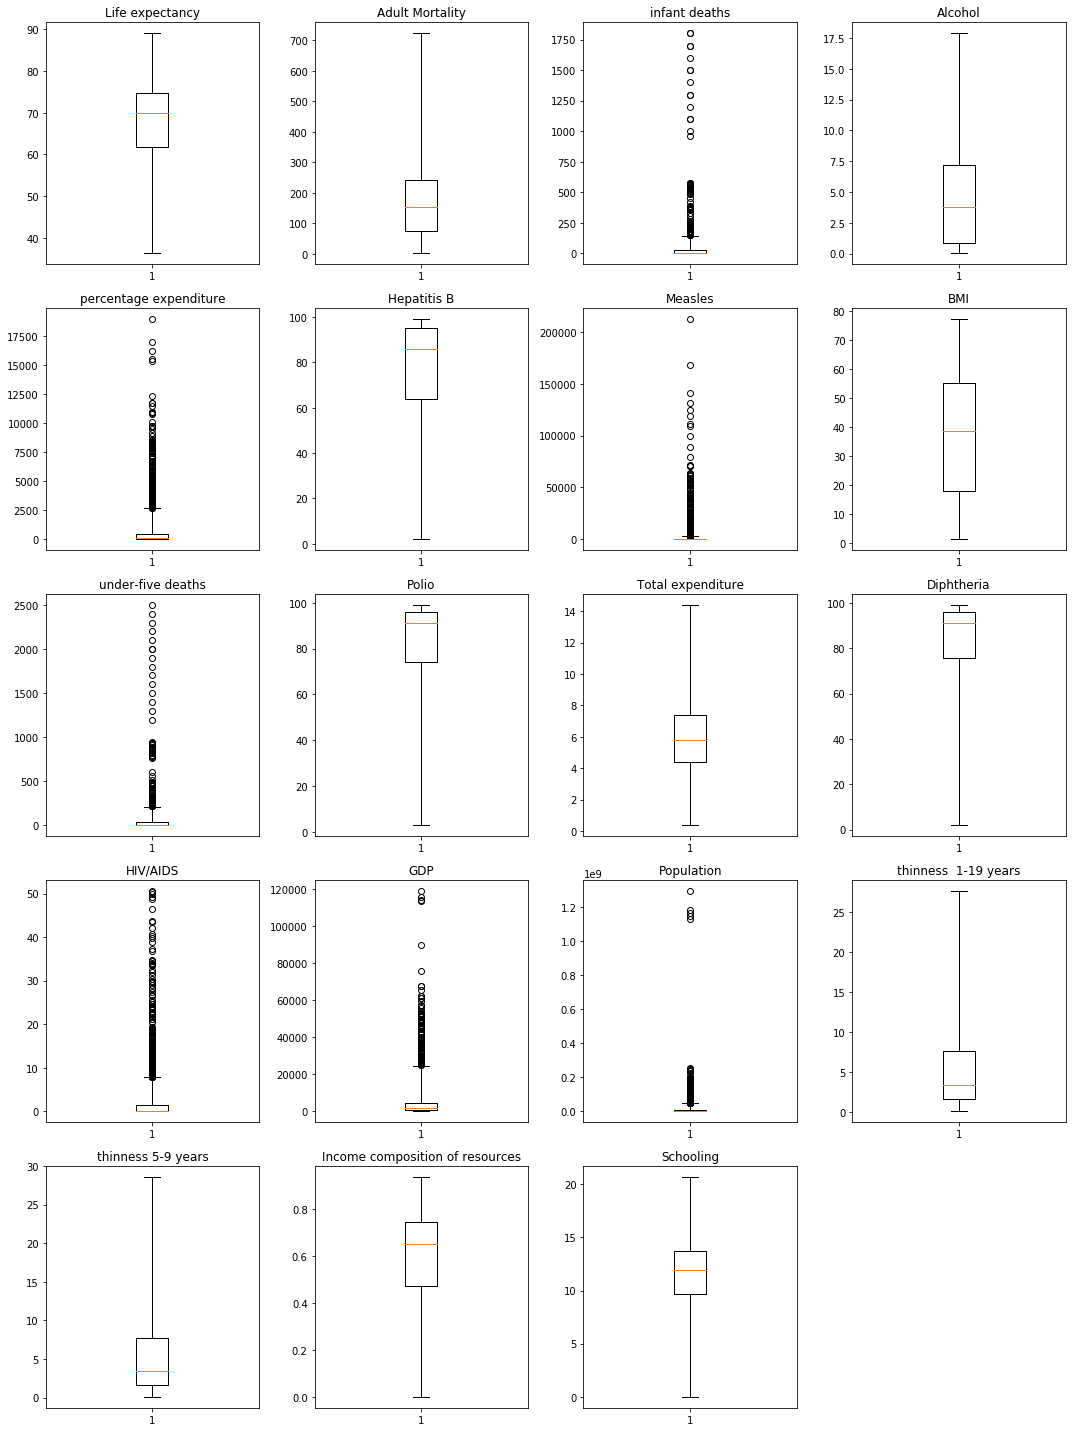

In [9]:
#looking for outliers and values that do not make sense
print(life.Status.unique()) #these values make sense

continuous = life.columns.values[3:] #gathering continuous variable column names

#plot box plots for all continuous variables
i = 1
plt.figure(figsize=(15,20))
for col in continuous:
  plt.subplot(5,4,i)
  plt.boxplot(life[col],whis=5) #high whisker value
  plt.title(col)
  i += 1
plt.tight_layout()
plt.show()

Variables with outliers:

1. Infant deaths
2. Percentage Expenditure
3. Measles
4. Under 5 deaths
6. HIV/AIDS
7. GDP
8. Population





Do any of these have values that do not make sense?

In [0]:
#infant deaths is the number of infant deaths per 1000 population in a year
#there are some really high numbers here, but I am not sure if this includes miscarriages
#if it includes miscarriages, then there could be multiple deaths per one woman 
life[life['infant deaths']>1000]
#all in India, maybe not bad data

#measles is the number of reported measle cases per 1000 population
#should not exceed 1000
life_clean = life[life['Measles']<=1000]

#under 5 deaths is the number of under 5 year olds that died per 1000 population in a year
#should not exceed 1000
life_clean = life_clean[life_clean['under-five deaths']<=1000]


There are clearly still outliers here, but there is global inequality. I decided to split the boxplots into Developed and Developing to better identify any data values that are errors

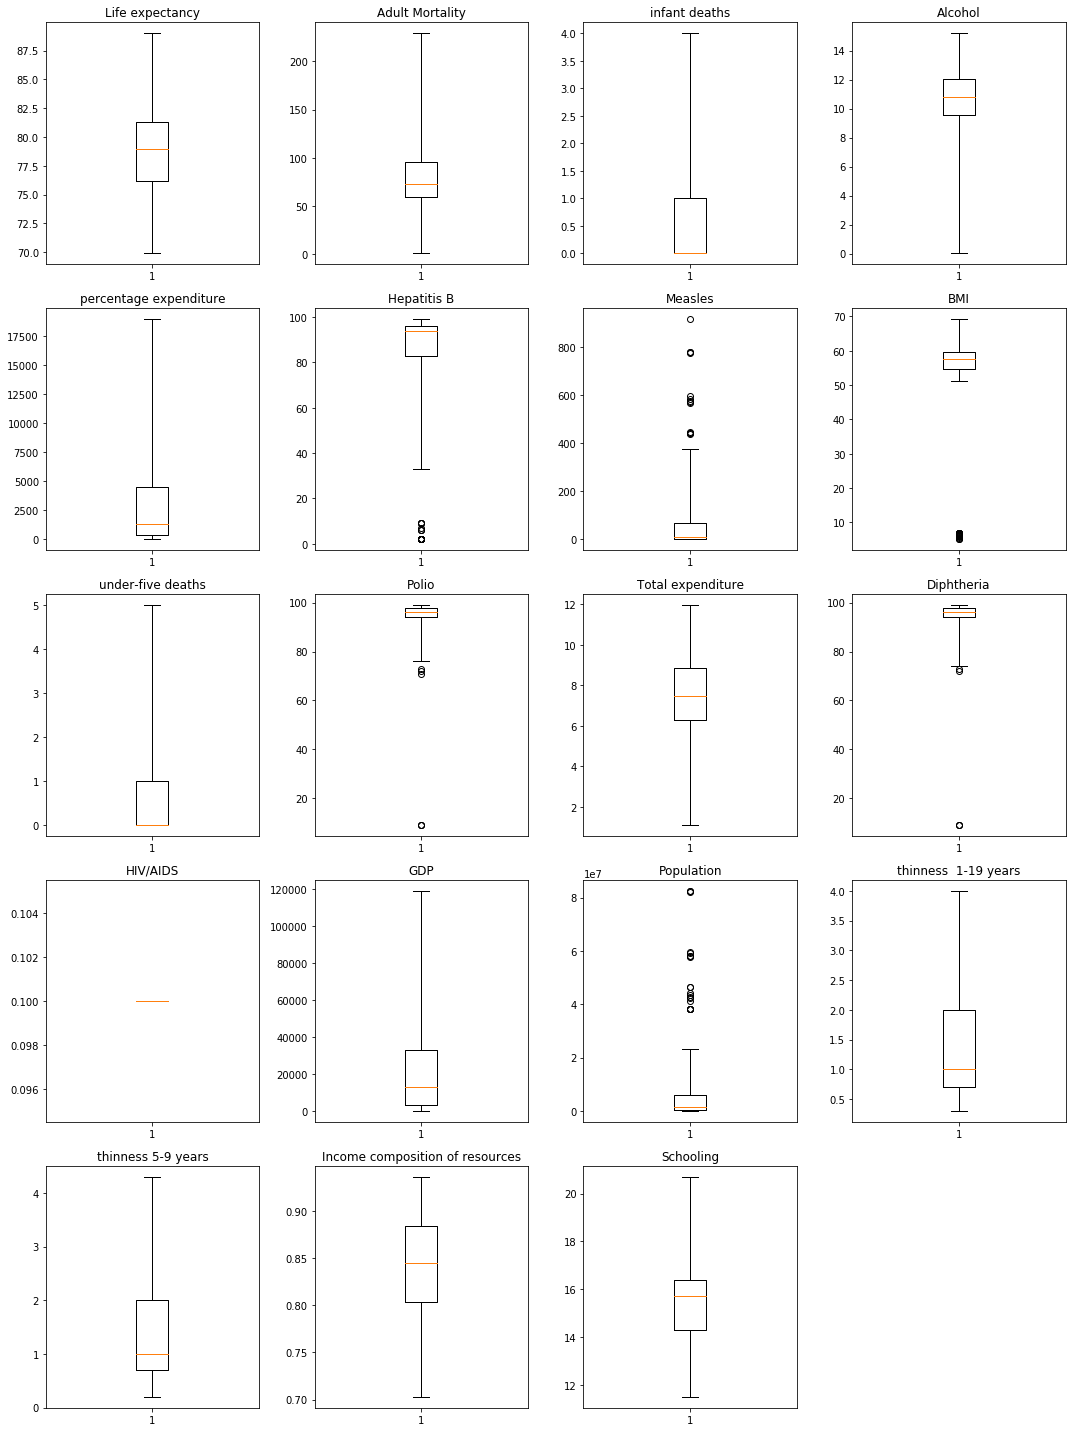

In [11]:
#Box Plots for Developed Countries
i = 1
plt.figure(figsize=(15,20))
for col in continuous:
  plt.subplot(5,4,i)
  plt.boxplot(life_clean[life_clean['Status']=='Developed'][col],whis=5) #high whisker value
  plt.title(col)
  i += 1
plt.tight_layout()
plt.show()

Variables with outliers:
1. Hepatitus B
2. Measles
3. BMI
4. Polio
5. Diphtheria
6. Population

In [0]:
#Hepatitus B

life_clean[(life_clean['Status']=='Developed') & (life_clean['Hepatitis B']<20) ]

#checking each country with low values
#life_clean[life_clean['Country']=='Belgium'] 
#life_clean[life_clean['Country']=='Germany']
#life_clean[life_clean['Country']=='Latvia']
#life_clean[life_clean['Country']=='Malta']
#life_clean[life_clean['Country']=='Netherlands'] 
#life_clean[life_clean['Country']=='Portugal']

#low values are data entry errors, drop from dataset
life_clean.drop(np.array(life_clean[(life_clean['Status']=='Developed') & (life_clean['Hepatitis B'] < 20)].index),inplace=True)


In [0]:
#Measles

life_clean[(life_clean['Status']=='Developed') & (life_clean['Measles'] > 400)]
#countries have one or two entry errors, but Germany may have high measle rates, the data is all over the place

#life_clean[life_clean['Country']=='Germany'] 

#I won't drop Germany observations
life_clean.drop(np.array(life_clean[(life_clean['Status']=='Developed') & (life_clean['Country']!= 'Germany') & (life_clean['Hepatitis B'] < 20)].index),inplace=True)


In [0]:
#BMI

life_clean[(life_clean['Status']=='Developed') & (life_clean['BMI'] < 10)]

#spot checking, these countries have BMIs in the 50-60 range, so these are entry errors
life_clean.drop(np.array(life_clean[(life_clean['Status']=='Developed') & (life_clean['BMI'] < 10)].index),inplace=True)


In [0]:
#Polio

life_clean[(life_clean['Status']=='Developed') & (life_clean['Polio'] < 20)]

#entry errors, drop these rows
life_clean.drop(np.array(life_clean[(life_clean['Status']=='Developed') & (life_clean['Polio'] < 20)].index),inplace=True)


In [0]:
#Diphtheria

life_clean[(life_clean['Status']=='Developed') & (life_clean['Diphtheria']<20)] #one outlier in germany
#life_clean[(life_clean['Country']=='Germany')]  looking at the country over the years, it is definitely an outlier

life_clean.replace({'Diphtheria':1010},life_clean[(life_clean['Country']=='Germany')].mean(),inplace= True ) #replace outlier with mean

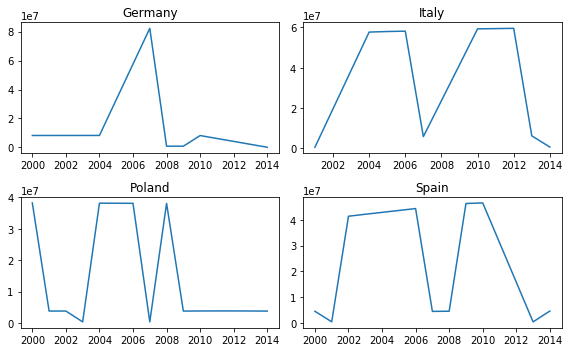

In [17]:
#Population

life_clean[(life_clean['Status']=='Developed') & (life_clean['Population'] > 30000000)]

#checking trends over time for population
countries = ['Germany','Italy','Poland','Spain']


j=1
plt.figure(figsize=(8,5))
for x in countries:
  plt.subplot(2,2,j)
  plt.plot(life_clean[life_clean['Country']==x]['Year'],life_clean[life_clean['Country']==x]['Population'])
  plt.title(x)
  j+=1
plt.tight_layout()
plt.show()

In [0]:
#jumps in population from year to year is likely data collection errors
life_clean.drop(np.array(life_clean[(life_clean['Status']=='Developed') & (life_clean['Population'] > 30000000 )].index),inplace=True)

Moving on to Developing Countries

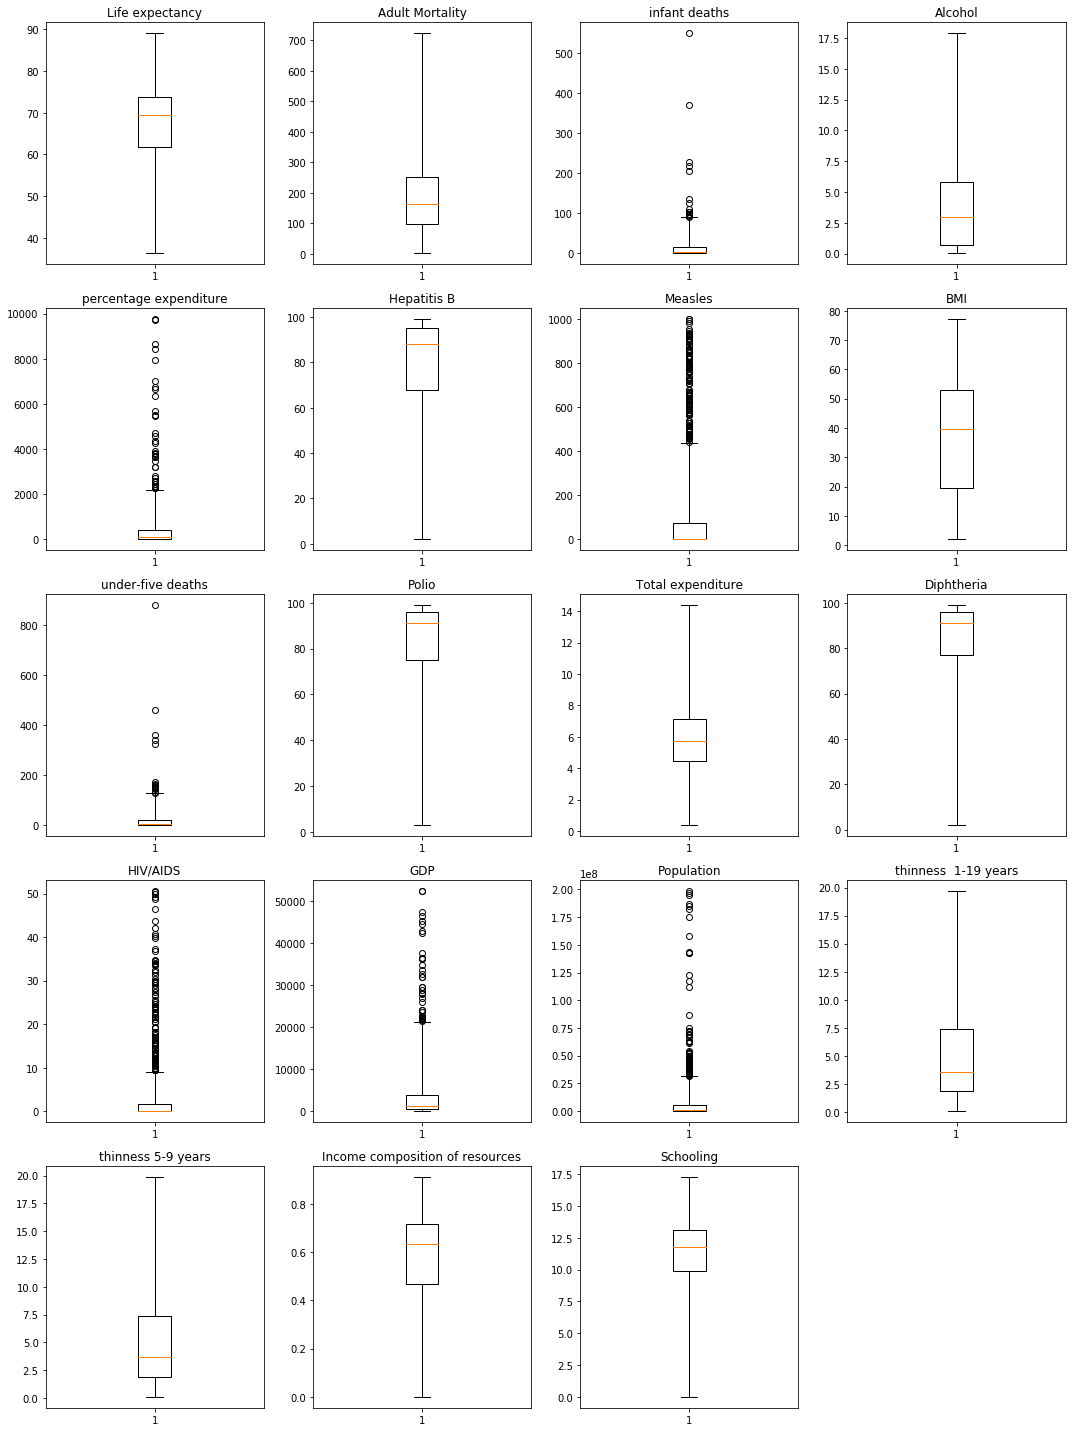

In [19]:
i = 1
plt.figure(figsize=(15,20))
for col in continuous:
  plt.subplot(5,4,i)
  plt.boxplot(life_clean[life_clean['Status']=='Developing'][col],whis=5) #high whisker value
  plt.title(col)
  i += 1
plt.tight_layout()
plt.show()

Variables with outliers:
1. Infant deaths
2. Percentage expenditure
3. Measles
4. Under five deaths
5. HIV/AIDS
6. GDP
7. Population

In [20]:
#Infant Deaths

life_clean[(life_clean['Status']=='Developing') & (life_clean['infant deaths'] > 150)]

#life_clean[life_clean['Country']=='Ethiopia'] doesn't appear to be bad data
#life_clean[life_clean['Country']=='Pakistan']
#life_clean[life_clean['Country']=='Nigeria']

#all records with high infant deaths are the only records for that country. So I will leave the outliers since I am not certain if they are entry errors

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
893,Ethiopia,2005,Developing,56.0,343.0,206,0.99,18.037531,47.0,357,13.8,323,56.0,4.20,44.0,3.7,161.626625,7672783.0,11.5,11.2,0.325,5.8
894,Ethiopia,2004,Developing,55.0,354.0,217,0.86,1.506962,47.0,73,13.5,342,54.0,4.23,4.0,4.1,135.762386,7462445.0,11.5,11.3,0.310,5.4
895,Ethiopia,2003,Developing,54.0,363.0,228,0.79,10.972019,47.0,228,13.2,360,55.0,4.64,37.0,4.4,118.873447,72545144.0,11.6,11.5,0.306,5.2
1903,Nigeria,2006,Developing,49.8,396.0,549,9.66,10.357794,27.0,704,19.9,879,46.0,3.66,4.0,5.3,119.743286,14261494.0,12.6,12.6,0.466,9.0
1949,Pakistan,2009,Developing,64.8,175.0,371,0.03,0.697216,78.0,863,21.3,460,7.0,2.94,71.0,0.1,16.639990,1674958.0,2.5,2.9,0.514,7.3


In [21]:
#percentage expenditure

life_clean[(life_clean['Status']=='Developing') & (life_clean['percentage expenditure'] > 2100)]

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
498,Canada,2013,Developing,81.8,67.0,2,8.20,9733.228019,55.0,83,65.8,2,91.0,1.67,91.0,0.1,52413.721160,35155451.0,0.5,0.5,0.909,15.9
499,Canada,2012,Developing,81.6,68.0,2,8.30,9748.636237,7.0,10,65.3,2,99.0,1.78,95.0,0.1,52496.694870,3475545.0,0.5,0.5,0.907,15.9
501,Canada,2010,Developing,81.2,7.0,2,8.40,8649.674911,56.0,99,64.1,2,88.0,11.20,89.0,0.1,47447.476200,345274.0,0.5,0.4,0.898,15.9
503,Canada,2008,Developing,87.0,74.0,2,8.30,8433.936814,28.0,62,63.0,2,89.0,1.30,92.0,0.1,46596.335990,33245773.0,0.5,0.4,0.897,15.8
504,Canada,2007,Developing,85.0,74.0,2,8.30,7946.743581,14.0,101,62.5,2,9.0,9.83,94.0,0.1,44544.526800,32887928.0,0.5,0.4,0.894,15.8
506,Canada,2005,Developing,81.0,76.0,2,8.00,6333.177967,14.0,6,61.3,2,93.0,9.57,93.0,0.1,36189.588380,32312.0,0.5,0.4,0.886,15.8
507,Canada,2004,Developing,80.0,77.0,2,7.80,5513.329924,14.0,7,6.6,2,91.0,9.56,91.0,0.1,31979.871950,31995.0,0.5,0.4,0.881,15.8
508,Canada,2003,Developing,79.7,78.0,2,7.70,4687.845565,14.0,15,6.0,2,88.0,9.54,91.0,0.1,28172.148830,31676.0,0.5,0.4,0.877,15.8
509,Canada,2002,Developing,79.5,79.0,2,7.70,3895.856308,14.0,6,59.3,2,88.0,9.37,88.0,0.1,24167.843100,31362.0,0.5,0.4,0.872,15.8
510,Canada,2001,Developing,79.4,8.0,2,7.60,3665.089703,14.0,34,58.5,2,88.0,9.10,89.0,0.1,23691.594720,31819.0,0.5,0.4,0.867,15.8


In [0]:
#France, Canada, Greece and Israel are developed countries, misclassified in this data

dev = ['France','Canada','Israel','Greece']

for country in dev:
  life_clean.loc[life_clean['Country']==country,'Status'] = 'Developed'

In [23]:
#percentage expenditure

life_clean[(life_clean['Status']=='Developing') & (life_clean['percentage expenditure'] > 2100)]
#percentage expenditure is high for multiple years in a row for these countries, so its not entry errors

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
545,Chile,2014,Developing,83.0,83.0,2,7.16,2352.999591,95.0,0,63.1,2,95.0,7.79,95.0,0.1,14817.377780,17613798.0,0.8,0.8,0.841,16.2
546,Chile,2013,Developing,81.0,84.0,2,7.20,2442.222054,9.0,0,62.5,2,9.0,7.53,91.0,0.1,15941.397220,17462982.0,0.8,0.8,0.831,15.6
547,Chile,2012,Developing,79.9,84.0,2,6.76,2260.777642,9.0,0,61.8,2,9.0,7.24,9.0,0.1,15431.929300,1739746.0,0.8,0.8,0.826,15.5
628,Costa Rica,2012,Developing,79.2,97.0,1,3.34,2568.237059,91.0,0,57.5,1,9.0,9.56,91.0,0.1,9985.369590,4654122.0,1.8,1.7,0.758,13.6
629,Costa Rica,2011,Developing,79.0,98.0,1,3.41,2429.854745,84.0,0,56.5,1,82.0,9.73,85.0,0.1,9186.596390,46474.0,1.8,1.7,0.752,13.4
630,Costa Rica,2010,Developing,78.1,16.0,1,3.58,2377.010299,89.0,0,55.5,1,93.0,9.66,88.0,0.1,8199.414621,454528.0,1.8,1.8,0.749,13.3
868,Estonia,2014,Developing,77.3,122.0,0,0.01,2700.073050,93.0,0,59.4,0,93.0,6.38,93.0,0.1,19941.455320,1314545.0,1.9,1.9,0.860,16.5
870,Estonia,2012,Developing,76.3,135.0,0,0.01,2263.103797,94.0,4,58.5,0,94.0,6.36,94.0,0.1,17421.892200,1322696.0,1.9,1.9,0.850,16.5
871,Estonia,2011,Developing,76.1,138.0,0,0.01,2146.945741,94.0,7,58.0,0,93.0,5.83,93.0,0.1,17454.843420,1327439.0,1.9,2.0,0.838,16.4
2815,Uruguay,2010,Developing,76.3,118.0,0,6.21,2331.532804,95.0,0,61.2,1,95.0,8.63,95.0,0.1,11938.212000,3374415.0,1.5,1.5,0.777,15.6


In [24]:
#Measles has no clear small pack of outliers, so I will leave the outliers. This may reduce how correlated this variable is to life expectancy

#Under five Deaths
life_clean[(life_clean['Status']=='Developing') & (life_clean['under-five deaths'] > 250)]
#same countries as high infant deaths, not data entry errors so I will keep the observations

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
893,Ethiopia,2005,Developing,56.0,343.0,206,0.99,18.037531,47.0,357,13.8,323,56.0,4.20,44.0,3.7,161.626625,7672783.0,11.5,11.2,0.325,5.8
894,Ethiopia,2004,Developing,55.0,354.0,217,0.86,1.506962,47.0,73,13.5,342,54.0,4.23,4.0,4.1,135.762386,7462445.0,11.5,11.3,0.310,5.4
895,Ethiopia,2003,Developing,54.0,363.0,228,0.79,10.972019,47.0,228,13.2,360,55.0,4.64,37.0,4.4,118.873447,72545144.0,11.6,11.5,0.306,5.2
1903,Nigeria,2006,Developing,49.8,396.0,549,9.66,10.357794,27.0,704,19.9,879,46.0,3.66,4.0,5.3,119.743286,14261494.0,12.6,12.6,0.466,9.0
1949,Pakistan,2009,Developing,64.8,175.0,371,0.03,0.697216,78.0,863,21.3,460,7.0,2.94,71.0,0.1,16.639990,1674958.0,2.5,2.9,0.514,7.3


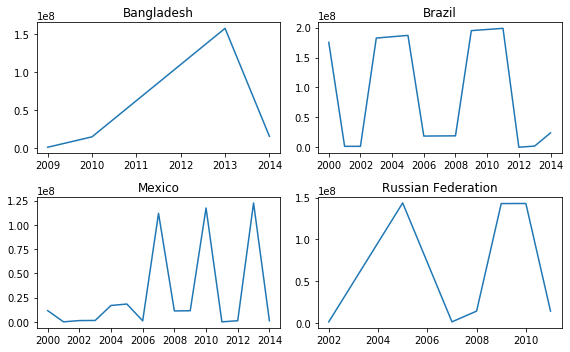

In [25]:
#HIV/AIDS
#has no clear small pack of outliers, so I will leave the outliers. This may reduce how correlated this variable is to life expectancy

#GDP
#recassifying countries as Developed eliminated major outliers

#Population

life_clean[(life_clean['Status']=='Developing') & (life_clean['Population'] > 100000000)]

#checking trends over time
pop = ['Bangladesh','Brazil','Mexico','Russian Federation']

j=1
plt.figure(figsize=(8,5))
for p in pop:
  plt.subplot(2,2,j)
  plt.plot(life_clean[life_clean['Country']==p]['Year'],life_clean[life_clean['Country']==p]['Population'])
  plt.title(p)
  j+=1
plt.tight_layout()
plt.show()

In [0]:
#outliers are likely errors so I will drop those rows except for Bangledesh which has a plausible trend
life_clean.drop(np.array(life_clean[(life_clean['Status']=='Developing') & (life_clean['Population'] > 100000000 ) & (life_clean['Country'] != 'Bangladesh')].index),inplace=True)

### Feature Selection

Are there any variables that could be created from interactions? For many of the medical conditions, it makes sense that these would have more impact when the countries GDP is low, because there would be less resources to fight the condition

In [27]:
#creating a new dataframe with GDP interactions
variables = ['Adult Mortality' ,'infant deaths', 'Alcohol',
 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI',
 'under-five deaths' ,'Polio', 'Total expenditure', 'Diphtheria' ,'HIV/AIDS',
 'GDP', 'Population', 'thinness  1-19 years' ,'thinness 5-9 years',
 'Income composition of resources' ,'Schooling']

interact = life_clean.copy()
for var in variables:
  interact[var] = interact[var]*life_clean.GDP
GDP_interact_corr = interact.corr()

significant = GDP_interact_corr[(GDP_interact_corr['Life expectancy'] > .5) | (GDP_interact_corr['Life expectancy'] < -.5) ]

significant['Life expectancy'].sort_values()


Life expectancy    1.0
Name: Life expectancy, dtype: float64

My hypothesis on the interaction variable with GDP is incorrect, there were not any interaction variables with significant correlation with life expectancy

In [28]:
#looking at correlations between continuous variables and life expectancy
from scipy import stats
corr = life_clean.corr()
corr
significant = corr[(corr['Life expectancy'] > .5) | (corr['Life expectancy'] < -.5) ]
significant['Life expectancy']

Life expectancy                    1.000000
Adult Mortality                   -0.686706
BMI                                0.631463
HIV/AIDS                          -0.598998
thinness  1-19 years              -0.514497
thinness 5-9 years                -0.513669
Income composition of resources    0.679417
Schooling                          0.716574
Name: Life expectancy, dtype: float64

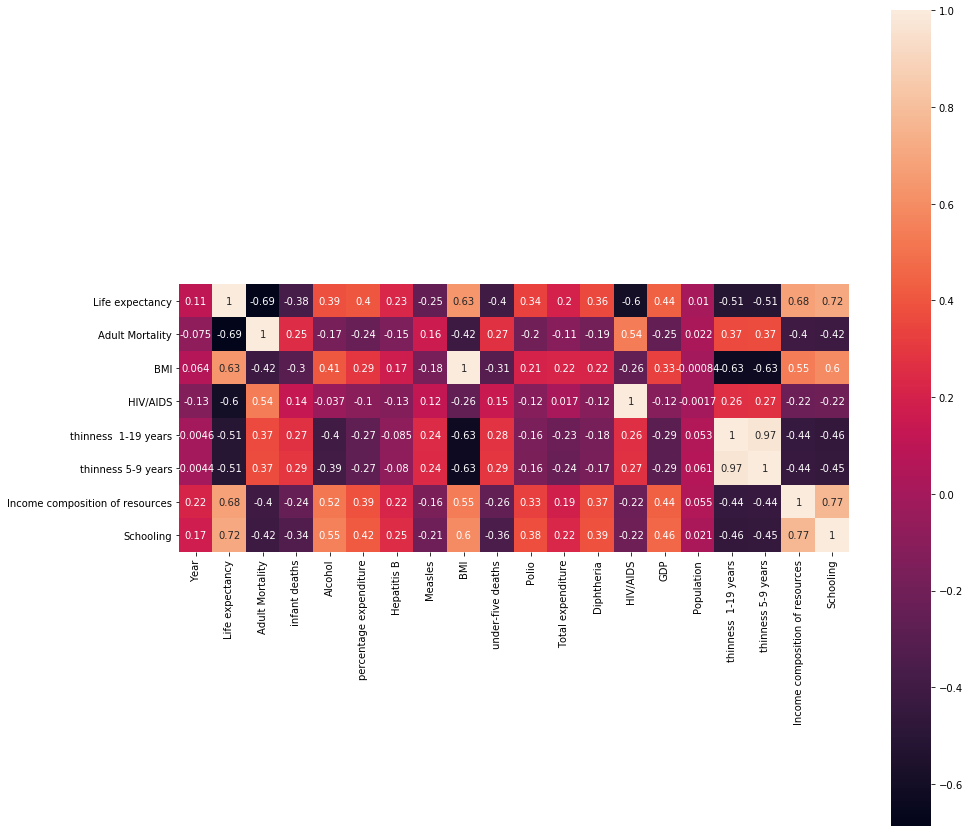

In [29]:
#looking now for variables that are correlated with each other
import seaborn as sns
plt.figure(figsize = (15,15))
sns.heatmap(significant,square = True, annot = True)

Thinness 1-19 years and Thinness 5-9 years are very highly correlated. I will only keep Thinness 1-19 years because it has a slightly higher correlation with life expectancy

In [30]:
life_clean.groupby(by='Status').mean()['Life expectancy']

Status
Developed     79.280876
Developing    66.618067
Name: Life expectancy, dtype: float64

In [31]:
print(stats.normaltest(life_clean[life_clean['Status']=='Developed']['Life expectancy']))
print(stats.normaltest(life_clean[life_clean['Status']=='Developing']['Life expectancy']))
print('_'*100)
print(stats.mannwhitneyu(life_clean[life_clean['Status']=='Developed']['Life expectancy'],life_clean[life_clean['Status']=='Developing']['Life expectancy']))
#reject null and conclude there is a significant difference between the means of the populations

NormaltestResult(statistic=0.2748825653495321, pvalue=0.8715855256654736)
NormaltestResult(statistic=109.86846292136603, pvalue=1.3879263117722892e-24)
____________________________________________________________________________________________________
MannwhitneyuResult(statistic=19620.5, pvalue=4.333693719745262e-107)


Features to be selected for PCA:

*   Adult Mortality 
*   BMI
*   HIV/AIDS
*   Thinness 1-19 Years
*   Income Composition of Resources
*   Schooling
*   Status



### PCA

In [32]:
#normalize the data
features = life_clean[['Adult Mortality','BMI','HIV/AIDS','thinness  1-19 years','Income composition of resources','Schooling']]

target = life_clean['Life expectancy']

X = StandardScaler().fit_transform(features)

#perform PCA
pca = PCA(n_components = 5)
components = pca.fit_transform(X)

pca.explained_variance_ratio_


array([0.5393642 , 0.17987304, 0.1154794 , 0.069922  , 0.05857593])

In [33]:
pca.explained_variance_ratio_.cumsum()
#first three components explain over 80% of variance

array([0.5393642 , 0.71923723, 0.83471663, 0.90463863, 0.96321455])

In [34]:
target.reset_index(drop=True, inplace=True) #resetting the index so it lines up with the component dataframe 

principalDf = pd.DataFrame(data = components[:,0:3]
             , columns = ['component 1','component 2','component 3']) #only keep first 3

component_target = pd.concat([principalDf,target],axis=1)

component_target

,component 1,component 2,component 3,Life expectancy
0,2.629421,-0.847954,-2.110671,59.9
1,2.681445,-0.888345,-2.134462,59.9
2,3.706969,-1.325920,-1.922127,57.0
3,3.805999,-1.369590,-1.907811,56.7
4,-1.846627,0.097802,0.205786,77.8
...,...,...,...,...
1508,4.449686,4.508449,0.550900,44.6
1509,4.679695,4.891219,0.505288,44.3
1510,4.777318,5.252617,0.368324,44.5
1511,2.028381,3.530392,1.065343,44.8


In [35]:
#checking to make sure there is still high correlation between the components and life expectancy
component_target.corr()

,component 1,component 2,component 3,Life expectancy
component 1,1.000000e+00,9.674681e-17,1.058475e-17,-0.864325
component 2,9.674681e-17,1.000000e+00,1.316972e-16,-0.180493
component 3,1.058475e-17,1.316972e-16,1.000000e+00,-0.145236
Life expectancy,-8.643246e-01,-1.804926e-01,-1.452356e-01,1.000000


### Summary

After filling in missing values in the dataset, and then dropping the rows that could not be filled via interpolation, much effort went in to eliminating outliers where possible. There were lots of data entry errrors found and dropped. 

In [36]:
print('total number of rows dropped:',len(life)-len(life_clean))
print('percentage of data dropped:',round((len(life)-len(life_clean))/len(life)*100,2), '%')

total number of rows dropped: 474
percentage of data dropped: 23.86 %


After data cleaning, all variables were examined for correlation with the variable of interest, Life Expectancy. The following variables had significant (above r=.5 or below r=-.5) correlations with Life Expectancy:

*   Adult Mortality : An increase in adult mortality is correlated to a decrease in life expectancy
*   BMI : An increase in BMI is correlated to an increase in life expectancy
*   HIV/AIDS : An increase in HIV/AIDS is correlated to a decrease in liffe expectancy
*   Thinness 1-19 Years: An increase in thinness 1-19 years is correlated to a decrease in life expectancy 
*   Income Composition of Resources : An increase in income composition of resources is correlated to an increase in life expectancy
*   Schooling : An increase in schooling is correlated to an increase in life expectancy
*   Status : A status of 'Developed' is correlated with a higher life expectancy than a status of 'Developing'



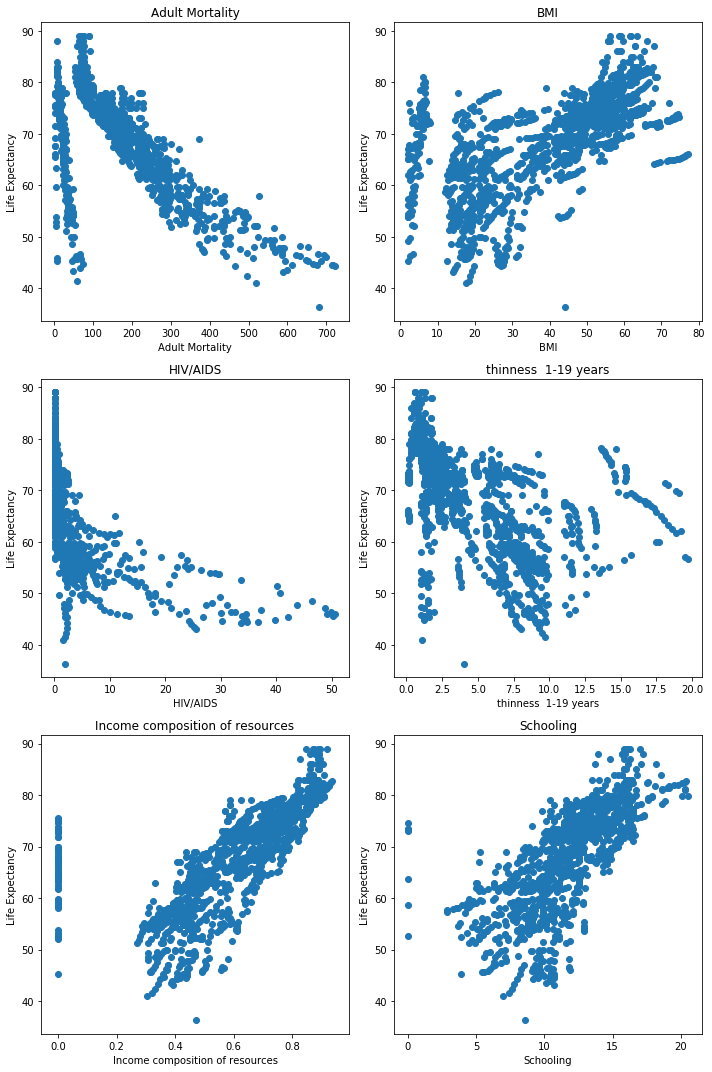

In [37]:
#plot scatter plots for above variables to visualize relationships
columns = ['Adult Mortality','BMI','HIV/AIDS','thinness  1-19 years','Income composition of resources','Schooling']

i = 1
plt.figure(figsize=(10,15))
for col in columns:
  plt.subplot(3,2,i)
  plt.scatter(life_clean[col],life_clean['Life expectancy'])
  
  plt.xlabel(col)
  plt.ylabel('Life Expectancy')
  plt.title(col)
  i += 1
plt.tight_layout()
plt.show()

Income composition fo resources and schooling have the least amount of 2D outliers

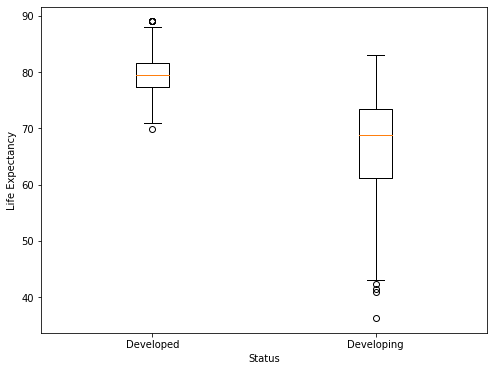

In [38]:
#visualize relationship between Status and life expectancy
plt.figure(figsize=(8,6))
plt.boxplot([life_clean[life_clean['Status']=='Developed']['Life expectancy'],
            life_clean[life_clean['Status']=='Developing']['Life expectancy']])
plt.xticks((1,2),['Developed','Developing'])
plt.xlabel('Status')
plt.ylabel('Life Expectancy')
plt.show()


The boxplot above shows that developed countries have higher life expectancies than developing countries (which was confirmed to be significant with statistical tests), and also that developing countries have a higher spread of life expectancies. There are few outliers for this feature

Finally, Principal Component Analysis was performed after identifying the correlations above to attempt to reduce the dimensionality. The first three components represented 83% of the variance in the data. 

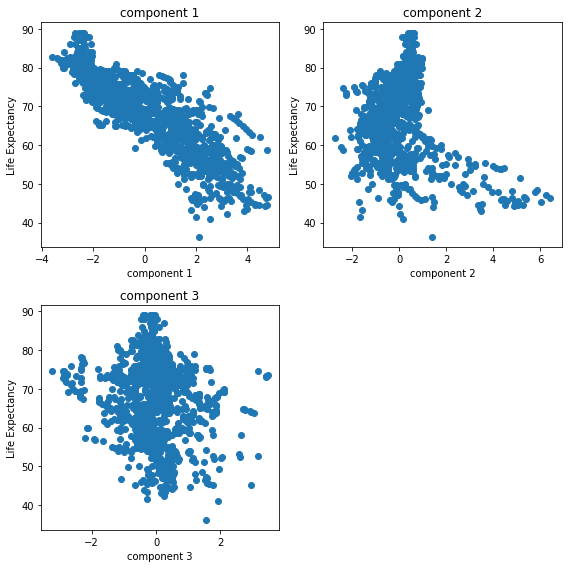

In [39]:
columns = ['component 1','component 2','component 3']

i = 1
plt.figure(figsize=(8,8))
for col in columns:
  plt.subplot(2,2,i)
  plt.scatter(component_target[col],component_target['Life expectancy'])
  
  plt.xlabel(col)
  plt.ylabel('Life Expectancy')
  plt.title(col)
  i += 1
plt.tight_layout()
plt.show()

Based on this visualizaton, I might consider only including the first two components, depending on the model that I ended up using.

In [0]:
#from google.colab import files
#life_clean.to_csv('filename.csv') 
#files.download('filename.csv')